In [1]:
from google.colab import drive
# monta tu unidad de google drive
drive.mount('/content/drive')

# cambiamos el directorio de trabajo a la carpeta donde está almacenado el dataset
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/HomoMex_2024/public_data_train_phase')

Mounted at /content/drive


In [2]:
import pandas as pd


#SE CARGAN LOS DATASETS LIBERADOS POR IBERLEF PARA LOS TRACK 1 Y 2
df_1 = pd.read_csv("track_1_train.csv",  sep=',')
df_2 = pd.read_csv("track_2_train.csv",  sep=',')

df_gen_B = pd.read_excel("contenidoB.xlsx")
df_gen_B['B'] = 1
df_gen_B['L'] = 0
df_gen_B['G'] = 0
df_gen_B['NR'] = 0
df_gen_B['T'] = 0
df_gen_B['O'] = 0

# Reorganizar las columnas
df_gen_B = df_gen_B[['content', 'L', 'G', 'B', 'T', 'O', 'NR']]



In [ ]:
df_2

,Unnamed: 0,content,L,G,B,T,O,NR
0,0,¡QUÉ POCA MADRE! ¡PERO EL JOTO @ManceraMiguelM...,1,1,0,0,0,0
1,1,Me considero un ser de luz!\n(Pero nunca le re...,0,1,0,0,0,0
2,2,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 vaya puñurl🤣🤣🤣🤣🤣🤣🤣🤣🤣 url,0,1,0,0,1,0
3,3,No llore jota,0,1,0,0,0,0
4,4,@mauritrevino_ pinche joto,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1066,1066,@Erik__Ra No uso desodorante ni artículos homo...,0,1,0,0,0,0
1067,1067,@bta_Demian Un maricón bárbaro.,0,1,0,0,0,0
1068,1068,🔥HOY vista la Tienda @Gravitymty\n➡Calle Matam...,0,0,0,0,1,0
1069,1069,Es un homosexual reprimido y por eso está rese...,0,1,0,0,0,0


In [3]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, \
multilabel_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

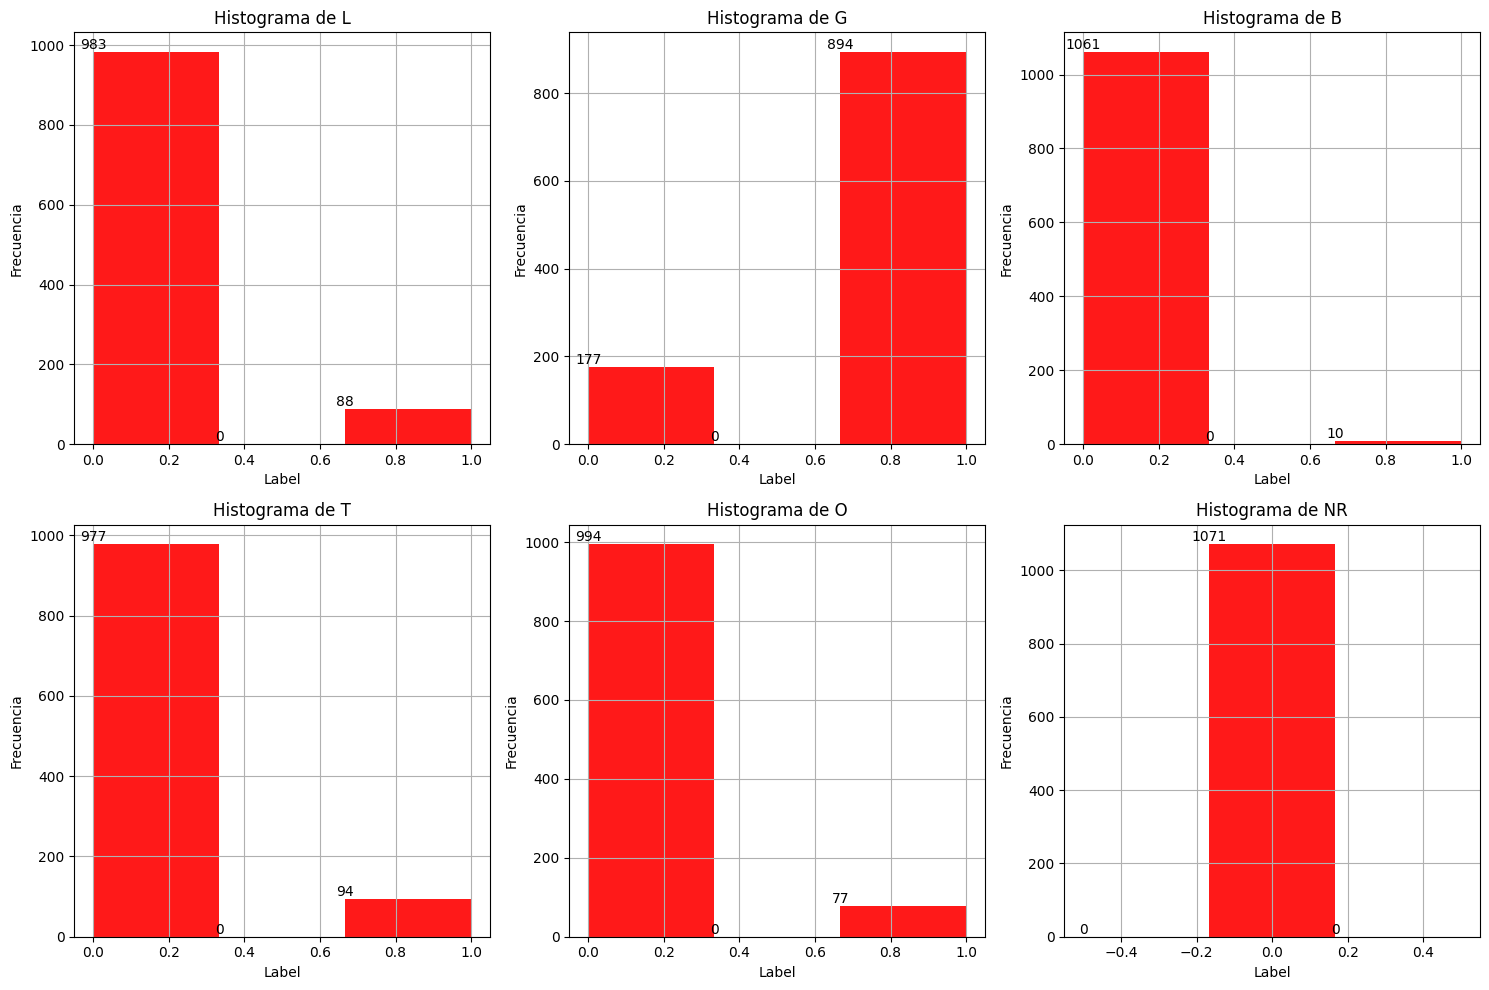

In [4]:
import matplotlib.pyplot as plt

# Crear una figura y subtramas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Clases disponibles
classes = ['L', 'G', 'B', 'T', 'O', 'NR']

# Iterar sobre las clases y crear histogramas en cada subtrama
for i, ax in enumerate(axes.flat):
    if i < len(classes):
        # Seleccionar la clase actual
        current_class = classes[i]

        # Crear histograma para la clase actual
        n, bins, patches = ax.hist(df_2[current_class], bins=3, color='red', alpha=0.9)
        ax.set_xlabel('Label')
        ax.set_ylabel('Frecuencia')
        ax.set_title(f'Histograma de {current_class}')
        ax.grid(True)

        # Agregar los valores de cada bin dentro del gráfico con rotación de 90 grados
        for count, (bin_, patch) in enumerate(zip(bins, patches)):
            ax.text(bin_, n[count], f"{int(n[count])}", ha='center', va='bottom')

# Ajustar el espacio entre subtramas
plt.tight_layout()

# Mostrar la figura
plt.show()

<!-- # FUNCIONES PARA PREPROCESAMIENTO Y LIMPIEZA DE TEXTO -->

# Funciones para pre-procesamiento y limpieza de texto

In [10]:
import pandas as pd
import re
import unicodedata

# Expresión regular para detectar emojis
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticonos
                           u"\U0001F300-\U0001F5FF"  # símbolos y pictogramas
                           u"\U0001F680-\U0001F6FF"  # transporte y símbolos de mapas
                           u"\U0001F1E0-\U0001F1FF"  # banderas (iOS)
                           "]+", flags=re.UNICODE)

# Función para limpiar un tweet
def limpiar_tweet(tweet):
    # Convertir a minúsculas
    tweet = tweet.lower()

    # Eliminar emojis
    tweet = re.sub(r'[\U00010000-\U0010ffff]', '', tweet)

    # Eliminar URLs
    tweet = re.sub(r'http\S+', '', tweet)

    # Eliminar hashtags
    tweet = re.sub(r'#\w+', '', tweet)

    # Eliminar menciones
    tweet = re.sub(r'@\w+', '', tweet)

    # Eliminar caracteres especiales excepto letras, espacios y emojis
    tweet = re.sub(r'[^a-zA-ZñÑáéíóúÁÉÍÓÚ\s]+', '', tweet)

    # Reemplazar palabras con acentos por su equivalente sin tilde
    tweet = ''.join((c for c in unicodedata.normalize('NFD', tweet) if unicodedata.category(c) != 'Mn'))

    # Eliminar espacios en blanco extras
    tweet = re.sub(r'\s+', ' ', tweet)

    return tweet.strip()

In [11]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer


nltk.download('stopwords')
nltk.download('punkt')

stopwords_es = set(stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')

def clean_text(text):
    # Convertir a minúsculas
    text = str(text).lower()

    # Eliminar emojis
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)

    # Eliminar enlaces
    text = re.sub(r'http\S+', '', text)

    # Eliminar hashtags
    text = re.sub(r'#\w+', '', text)

    # Eliminar menciones
    text = re.sub(r'@\w+', '', text)

    # Eliminar caracteres especiales excepto letras, espacios y emojis (nuevo)
    text = re.sub(r'[^a-zA-ZñÑáéíóúÁÉÍÓÚ\s]+', '', text)

    # Reemplazar palabras con acentos por su equivalente sin tilde (nuevo)
    text = ''.join((c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn'))

    # Eliminar espacios en blanco adicionales
    text = re.sub(r'\s+', ' ', text)

    # Tokenizar
    tokens = word_tokenize(text)

    # Eliminar stopwords
    tokens = [word for word in tokens if word not in stopwords_es]

    # Usar stems
    tokens = [stemmer.stem(word) for word in tokens]

    # Ignorar palabras que contienen dígitos o símbolos especiales
    tokens = [word for word in tokens if not any(char.isdigit() or not char.isalnum() for char in word)]

    # Eliminar palabras con menos de 3 caracteres
    tokens = [word for word in tokens if len(word) >= 3]

    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## El dataset del track 2 carece de datos para la clase NR. Por tanto se le agregan datos tomados de la clase NR pertenecientes al Track1

In [12]:
import pandas as pd

# Seleccionar las filas donde el valor de la columna 'label' es 'NR'
df_NR = df_1.loc[df_1['label'] == 'NR']

# Tomar las primeras 50 instancias del DataFrame filtrado
df_NR_50 = df_NR.head(50)
# # Renombrar la columna 'label' como 'NR'
df_NR_50 = df_NR_50.rename(columns={'label': 'NR'})
df_NR_50['NR'] = 1
df_NR_50['L'] = 0
df_NR_50['G'] = 0
df_NR_50['B'] = 0
df_NR_50['T'] = 0
df_NR_50['O'] = 0

# Reorganizar las columnas
df_NR_50 = df_NR_50[['content', 'L', 'G', 'B', 'T', 'O', 'NR']]


# # Leer el conjunto de entrenamiento desde el archivo CSV
train_set = pd.read_csv("track_2_train.csv", sep=',')

# Concatenar el conjunto de entrenamiento original con las primeras 50 instancias de 'NR'
train_set = pd.concat([train_set, df_NR_50], axis=0)
train_set.reset_index(drop=True, inplace=True)

## Se aplica limpieza al texto

In [13]:
train_set['content'] = train_set['content'].apply(lambda x: limpiar_tweet(x))
df_gen_B['content'] = df_gen_B['content'].apply(lambda x: limpiar_tweet(x))

In [14]:
# Función para obtener la etiqueta
def obtener_etiqueta(row):
    etiquetas = []
    if row['L'] == 1:
        etiquetas.append('L')
    if row['G'] == 1:
        etiquetas.append('G')
    if row['B'] == 1:
        etiquetas.append('B')
    if row['T'] == 1:
        etiquetas.append('T')
    if row['O'] == 1:
        etiquetas.append('O')
    if row['NR'] == 1:
        etiquetas.append('NR')
    return ''.join(etiquetas)

# Crear columna label
train_set['label'] = train_set.apply(obtener_etiqueta, axis=1)

clases_frecuencias = train_set['label'].value_counts()


In [17]:
clases_frecuencias = train_set['label'].value_counts()

print("Cantidad de clases y sus frecuencias:")
print(clases_frecuencias)

Cantidad de clases y sus frecuencias:
label
G        830
T         66
L         57
NR        50
O         33
GO        28
LG        20
TO        10
GT         7
LT         5
B          4
GB         3
LGT        2
LGTO       1
LGO        1
GTO        1
LBTO       1
BO         1
LGBTO      1
Name: count, dtype: int64


In [18]:
train_set_filt = train_set[train_set['label'].isin(['G', 'T', 'L', 'O', 'GO', 'LG', 'GT', 'B', 'NR'])]

In [19]:
train_labels = train_set.drop(['content'], axis = 1)
labels = ['L', 'G', 'B', 'T', 'O', 'NR']

# train_set_filt_HIST = train_set_filt.drop(['content', 'label'], axis = 1)
# labels = ['G', 'T', 'L', 'O', 'GO', 'LG', 'GT', 'B', 'NR']

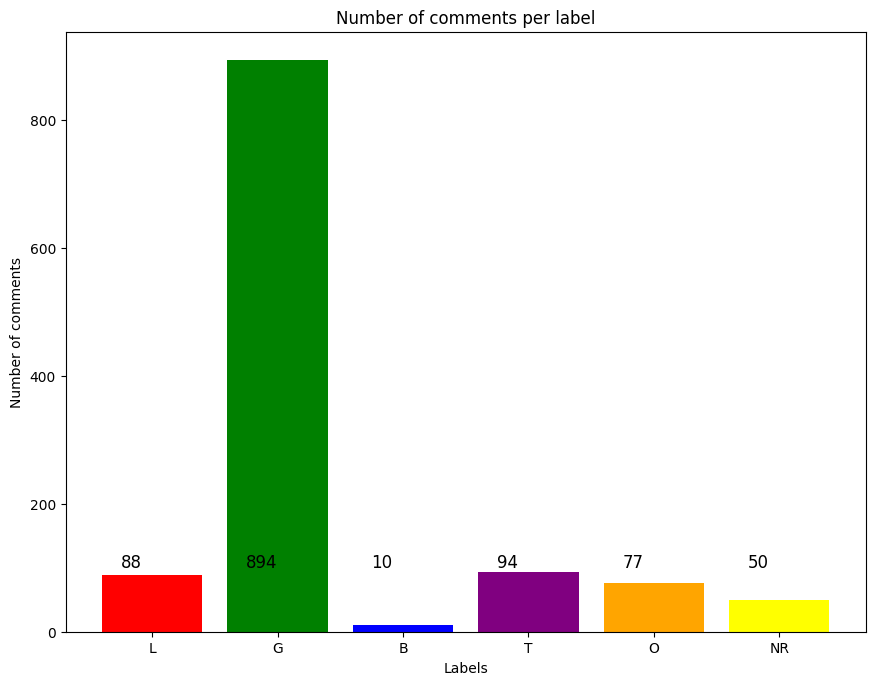

In [20]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
total_count = []
for label in labels:
    total_count.append(len(train_set[train_set[label] == 1]))
ax.bar(labels,total_count, color=['red', 'green', 'blue', 'purple', 'orange', 'yellow'])
for i,data in enumerate(total_count):
    plt.text(i-.25,
              data/total_count[i]+100,
              total_count[i],
              fontsize=12)
plt.title('Number of comments per label')
plt.xlabel('Labels')
plt.ylabel('Number of comments')

plt.show()

# División de los datos en Train, Val y Test

In [41]:
from sklearn.model_selection import train_test_split

# Características y etiquetas
X = train_set_filt['content']  # Características
y = train_set_filt[['L', 'G', 'B', 'T', 'O', 'NR', 'label']]  # Etiquetas

# Dividir los datos en Train y test (85-15 en este caso con estratificación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=train_set_filt[['label']])

print('Tamaño conjunto de Train:', len(X_train))
print('Tamaño conjunto de Test :', len(X_test))
print(50*'-')

# Luego Train se divide en trainT y val (75-10 en este caso)
X_trainT, X_val, y_trainT, y_val = train_test_split(X_train, y_train,
        test_size=0.10, random_state=42, stratify=y_train[['label']])

print('Tamaño conjunto de trainT:', len(X_trainT))
print('Tamaño conjunto de val:', len(X_val))


Tamaño conjunto de Train: 930
Tamaño conjunto de Test : 165
--------------------------------------------------
Tamaño conjunto de trainT: 837
Tamaño conjunto de val: 93


In [42]:
y_trainT

,L,G,B,T,O,NR,label
246,0,1,0,0,0,0,G
623,0,1,0,0,0,0,G
327,0,1,0,0,0,0,G
1047,0,1,0,0,0,0,G
270,0,0,0,0,1,0,O
...,...,...,...,...,...,...,...
83,0,1,0,0,0,0,G
678,0,1,0,0,0,0,G
292,1,1,0,0,0,0,LG
39,0,1,0,0,0,0,G


In [39]:
# import numpy as np

# # Mapeo de etiquetas de clase a valores numéricos
# class_mapping = {'B': 0, 'G': 1, 'GO': 2, 'GT': 3, 'L': 4, 'LG': 5, 'NR': 6, 'O': 7, 'T': 8}

# # Filtrar el conjunto de datos
# train_set_filt = train_set[train_set['label'].isin(['G', 'T', 'L', 'O', 'GO', 'LG', 'GT', 'B', 'NR'])]

# # Características y etiquetas
# X = train_set_filt['content']  # Características
# y = train_set_filt['label']  # Etiquetas


# # Dividir los datos en Train y test (85-15 en este caso con estratificación)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# print('Tamaño conjunto de Train:', len(X_train))
# print('Tamaño conjunto de Test :', len(X_test))
# print(50*'-')

# # Luego Train se divide en trainT y val (90-10 en este caso)
# X_trainT, X_val, y_trainT, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42, stratify=y_train)

# print('Tamaño conjunto de trainT:', len(X_trainT))
# print('Tamaño conjunto de val:', len(X_val))

# # Convertir las etiquetas a valores numéricos usando el mapeo
# y_trainT_numeric = np.array([class_mapping[label] for label in y_trainT])
# y_val_numeric = np.array([class_mapping[label] for label in y_val])
# y_test_numeric = np.array([class_mapping[label] for label in y_test])

# # Calcula los recuentos de las clases en cada conjunto de datos
# trainT_counts = np.bincount(y_trainT_numeric)
# val_counts = np.bincount(y_val_numeric)
# test_counts = np.bincount(y_test_numeric)

# # Mostrar la cantidad de instancias de cada clase en cada conjunto
# print("\nConjunto de entrenamiento (trainT):")
# for label, count in zip(class_mapping.keys(), trainT_counts):
#     print(f"Clase {label}: {count} instancias")

# print("\nConjunto de validación (val):")
# for label, count in zip(class_mapping.keys(), val_counts):
#     print(f"Clase {label}: {count} instancias")

# print("\nConjunto de evaluación (test):")
# for label, count in zip(class_mapping.keys(), test_counts):
#     print(f"Clase {label}: {count} instancias")


Tamaño conjunto de Train: 930
Tamaño conjunto de Test : 165
--------------------------------------------------
Tamaño conjunto de trainT: 837
Tamaño conjunto de val: 93

Conjunto de entrenamiento (trainT):
Clase B: 3 instancias
Clase G: 635 instancias
Clase GO: 22 instancias
Clase GT: 5 instancias
Clase L: 43 instancias
Clase LG: 15 instancias
Clase NR: 39 instancias
Clase O: 25 instancias
Clase T: 50 instancias

Conjunto de validación (val):
Clase B: 0 instancias
Clase G: 70 instancias
Clase GO: 2 instancias
Clase GT: 1 instancias
Clase L: 5 instancias
Clase LG: 2 instancias
Clase NR: 4 instancias
Clase O: 3 instancias
Clase T: 6 instancias

Conjunto de evaluación (test):
Clase B: 1 instancias
Clase G: 125 instancias
Clase GO: 4 instancias
Clase GT: 1 instancias
Clase L: 9 instancias
Clase LG: 3 instancias
Clase NR: 7 instancias
Clase O: 5 instancias
Clase T: 10 instancias


In [32]:
y_test = y_test.drop(columns='label')
y_trainT = y_trainT.drop(columns='label')
y_val = y_val.drop(columns='label')

In [43]:
# L', 'G', 'B', 'T', 'O', 'NR'

# Asegurarse de que las etiquetas están en las columnas 'L', 'G', 'B', 'T', 'O', 'NR'
labels = ['L', 'G', 'B', 'T', 'O', 'NR']

# Mostrar la cantidad de instancias de "1" en cada clase en cada conjunto
print("Conjunto de entrenamiento (trainT):")
trainT_counts = y_trainT[labels].sum()
for label, count in zip(labels, trainT_counts):
    print(f"Clase {label}: {count} instancias")

print("\nConjunto de validación (val):")
val_counts = y_val[labels].sum()
for label, count in zip(labels, val_counts):
    print(f"Clase {label}: {count} instancias")

print("\nConjunto de evaluación (test):")
test_counts = y_test[labels].sum()
for label, count in zip(labels, test_counts):
    print(f"Clase {label}: {count} instancias")


Conjunto de entrenamiento (trainT):
Clase L: 58 instancias
Clase G: 677 instancias
Clase B: 3 instancias
Clase T: 55 instancias
Clase O: 47 instancias
Clase NR: 39 instancias

Conjunto de validación (val):
Clase L: 7 instancias
Clase G: 75 instancias
Clase B: 0 instancias
Clase T: 7 instancias
Clase O: 5 instancias
Clase NR: 4 instancias

Conjunto de evaluación (test):
Clase L: 12 instancias
Clase G: 133 instancias
Clase B: 1 instancias
Clase T: 11 instancias
Clase O: 9 instancias
Clase NR: 7 instancias


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# y_train = df_1['label'].tolist()
# y_train = df_2_var1['label'].tolist()
labels = ['L', 'G', 'B', 'T', 'O', 'NR']
# y_train = labels.tolist()


le = LabelEncoder()

print("antes de transform: ", labels[:10])
labels = le.fit_transform(labels)
LABELS = le.classes_
NUM_LABELS = len(LABELS)
print("después de transform:", labels[:10])

#print("antes de transform: ", y_test[:10])
#y_test = le.transform(y_test)
#print("después de transform:", y_test[:10])

idx2label={}
label2idx={}
for index, label in enumerate(LABELS):
    label2idx.update([(label, index)])
    idx2label.update([(index, label)])
#y_train_cat = to_categorical(y_train)
#y_test_cat = to_categorical(y_test)
print('Labels:', label2idx)

antes de transform:  ['L', 'G', 'B', 'T', 'O', 'NR']
después de transform: [2 1 0 5 4 3]
Labels: {'B': 0, 'G': 1, 'L': 2, 'NR': 3, 'O': 4, 'T': 5}


## Debido a la poca presencia de datos correspondientes a la clase B, se inyectan datos sintéticos al conjunto de entrenamiento

In [ ]:
import pandas as pd

# Agregar contenido de la columna 'content' de df_gen a X_trainT
X_train1 = pd.concat([X_trainT, df_gen_B['content']], axis=0)

# Agregar contenido de la columna 'label' de df_gen a y_trainT
y_train1 = pd.concat([y_trainT, df_gen_B[['L','G', 'B', 'T', 'O', 'NR']]], axis=0)


# Se define la SVM y la búsqueda de HPO

In [ ]:
#Con búsqueda de HPO
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

#-------------------------------------------------------------------------------
#USANDO OneVsRestClassifier

#-------------------PARA SVC-----------------
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),
    ('tf', TfidfTransformer()),
    ('svm', OneVsRestClassifier(SVC()))  # Aquí está el cambio
])

parameters = {
    'svm__estimator__C': [10], #[0.1, 1, 10, 100],
    'svm__estimator__gamma': [0.1]  #[1, 0.1, 0.01],
    #'svm__estimator__kernel': ['rbf', 'linear', 'poly']
}


grid_search = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring='f1', n_jobs=-1)

# Entrenamos el modelo utilizando GridSearchCV que incluye el conjunto de validación
grid_search.fit(X_train1, y_train1)

# Mostramos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

Mejores hiperparámetros encontrados:
{'svm__estimator__C': 10, 'svm__estimator__gamma': 0.1}


In [ ]:
from sklearn.metrics import classification_report

# predictions = pipeline.predict(X_val)
predictions = grid_search.predict(X_val)

print( classification_report(y_val, predictions, target_names=LABELS))

              precision    recall  f1-score   support

           B       1.00      0.57      0.73         7
           G       0.89      0.99      0.94        75
           L       0.00      0.00      0.00         0
          NR       0.83      0.71      0.77         7
           O       0.00      0.00      0.00         5
           T       0.00      0.00      0.00         4

   micro avg       0.89      0.85      0.87        98
   macro avg       0.45      0.38      0.41        98
weighted avg       0.81      0.85      0.82        98
 samples avg       0.89      0.87      0.87        98



## Se reentrena el modelo pero con los datos de TRAIN los cuales a su ves tiene los datos de validación. También se concatenan los datos sintéticos generados para la clase B.

In [ ]:
# Agregar contenido de la columna 'content' de df_gen a X_train
X_train = pd.concat([X_train, df_gen_B['content']], axis=0)

# Agregar contenido de la columna 'label' de df_gen a y_trainT
y_train = pd.concat([y_train, df_gen_B[['L','G', 'B', 'T', 'O', 'NR']]], axis=0)

y_train = y_train.drop(columns='label')
grid_search.fit(X_train, y_train)

# usamos el modelo para inferir las predicciones
predictions = grid_search.predict(X_test)
# predictions = pipeline.predict(X_test)

#predictions = pipeline.predict(X_aux)


In [ ]:
from sklearn.metrics import classification_report
print( classification_report(y_test, predictions, target_names=LABELS))
#print( classification_report(y_aux, predictions, target_names=LABELS))

              precision    recall  f1-score   support

           B       1.00      0.75      0.86        12
           G       0.94      0.98      0.96       133
           L       1.00      1.00      1.00         1
          NR       1.00      0.55      0.71        11
           O       0.00      0.00      0.00         9
           T       0.00      0.00      0.00         7

   micro avg       0.94      0.85      0.89       173
   macro avg       0.66      0.55      0.59       173
weighted avg       0.86      0.85      0.85       173
 samples avg       0.88      0.87      0.87       173



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calcular métricas
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
roc_auc = roc_auc_score(y_test, predictions, average='micro')

# Imprimir las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Micro-F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.8545454545454545
Precision: 0.9363057324840764
Recall: 0.8497109826589595
Micro-F1 Score: 0.8909090909090909
ROC AUC Score: 0.918735540289088


# SECCIÓN DE COMPETENCIA

In [ ]:
# Agregar contenido de la columna 'content' de df_gen_B a los datos de entrenamiento X
X = pd.concat([X, df_gen_B['content']], axis=0)



# Agregar contenido de la columna 'label' de df_gen_B a los datos de entrenamiento y
y = y.drop(columns='label')
y = pd.concat([y, df_gen_B[['L','G', 'B', 'T', 'O', 'NR']]], axis=0)


grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow',
                                        CountVectorizer(analyzer=<function clean_text at 0x79db07f89360>)),
                                       ('tf', TfidfTransformer()),
                                       ('svm',
                                        OneVsRestClassifier(estimator=SVC()))]),
             n_jobs=-1,
             param_grid={'svm__estimator__C': [10],
                         'svm__estimator__gamma': [0.1]},
             scoring='f1')

In [ ]:
df_test = pd.read_csv("track_2_public_test.csv",  sep=',')

df_test['content'] = df_test['content'].apply(lambda x: limpiar_tweet(x))

In [ ]:
df_test

,Unnamed: 0,sub_id,content
0,0,0_Track2,es mas chida la gente transfobica que lo acept...
1,1,1_Track2,a el ni lo menciones porque es joto jajaja
2,2,2_Track2,tenemos a la directiva mas puta marica del fut...
3,3,3_Track2,marica ya olvidaste como celebraste el gol con...
4,4,4_Track2,chinga a tu madre maricon de mierda tu y tu ho...
...,...,...,...
263,263,263_Track2,no puedo con el ex de mi primo que siendo joto...
264,264,264_Track2,oigan no sera un maricon resentido o alguien q...
265,265,265_Track2,joto jajaja
266,266,266_Track2,viejo loco y trastornado ademas punal


In [ ]:
X_test=df_test['content']

Test_predictions = grid_search.predict(X_test)

In [ ]:
# Crear un DataFrame con las columnas 'sub_id' y 'content' del DataFrame original
nuevo_data = df_test[['sub_id']].copy()

# Agregar la columna 'label' con los resultados de las predicciones
nuevo_data[['L','G', 'B', 'T', 'O', 'NR']] = Test_predictions

In [ ]:
nuevo_data

,sub_id,L,G,B,T,O,NR
0,0_Track2,0,0,0,0,0,0
1,1_Track2,0,1,0,0,0,0
2,2_Track2,0,1,0,0,0,0
3,3_Track2,0,1,0,0,0,0
4,4_Track2,0,1,0,0,0,0
...,...,...,...,...,...,...,...
263,263_Track2,0,1,0,0,0,0
264,264_Track2,0,1,0,0,0,0
265,265_Track2,0,1,0,0,0,0
266,266_Track2,0,1,0,0,0,0


In [ ]:
nuevo_data.to_csv('track_2_predictions.csv', index=False)